# MC data testing

* Data to be analyzed:
    * file name: test_100.csv
    * file format: 5 columns x n rows         
        * Column 1: time
        * Column 2: channel 0 
        * Column 3: channel 1 
        * Column 4: channel 2 
        * Column 5: channel 3 

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [ ]:
# Verify if dask exists, if not install it
try:
  import dask
except:
  %pip install dask
  import dask

In [2]:
# This 1st try is to understanding the code with Pandas,
# But it's interesting to change to Dask for large files and memory consumption.
file = '../data/test_100.csv'
df = pd.read_csv(file, encoding ='utf-8', sep=' ')
content = df.values
df.head(100000)

,-5e-08,-0.00355114,0.000883152,-0.000748827,-0.00711462
0,-4.999000e-08,-0.002702,0.000883,-0.000741,-0.007115
1,-4.998000e-08,-0.002185,0.000852,-0.000463,-0.007115
2,-4.997000e-08,-0.001969,0.000791,0.000039,-0.007115
3,-4.996000e-08,-0.001984,0.000713,0.000664,-0.007115
4,-4.995000e-08,-0.002092,0.000652,0.001282,-0.007115
...,...,...,...,...,...
99995,9.499600e-07,0.002470,-0.010758,-0.011310,0.040440
99996,9.499700e-07,0.002393,-0.010866,-0.011518,0.040409
99997,9.499800e-07,0.001938,-0.011083,-0.011881,0.040301
99998,9.499900e-07,0.001212,-0.011330,-0.012275,0.040177


In [3]:
# Each column in Numpy array from Pandas data frame 
x0 = np.array(content[:,0]) # Horizontal scale -> T = 0.001E-08 (-5.000E-08 - -4.999E-08) 
y0 = np.array(content[:,1]) # Vertical - Signal 0
y1 = np.array(content[:,2]) # Vertical - Signal 1
y2 = np.array(content[:,3]) # Vertical - Signal 2
y3 = np.array(content[:,4]) # Vertical - Signal 3

## 1. Preview of all channels pulses

Since the time (in $s$ units) in the first row is $-5E-08\;s$ and the second row is $-4.999E-08\;s$, then $dT = 0.001E-08\;s$ or $$dT = 10\;ps$$ 
This means that the sample rating is 100 GS/s.

The number of samples in an event is 100,000. The event starts at $-5E-08\;s$ and ends at $9.4999E-08\;s$

The total number of events is 99.

## 2. Preview of channels 0 and 1 pulses


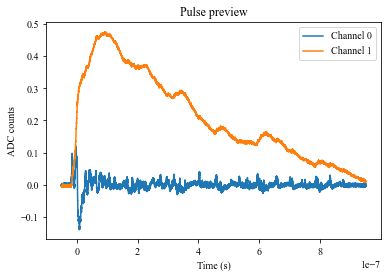

In [4]:
# Plot an event for analysis

#Inputs:
evt_nb = 17 # Select the number of event (between 0 to 99)

evt_smp = 100000 # Number of samples in an event
evt_sta = evt_nb * evt_smp # Event start
evt_end = evt_sta + evt_smp - 1 # Event end
evt_rng = range(evt_sta, evt_end) # Event range

plt.plot(x0[evt_rng], y0[evt_rng], label="Channel 0") # Plot channel 0 
plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1
plt.xlabel('Time (s)')
plt.ylabel('ADC counts')
plt.title('Pulse preview')
plt.legend()

## 3. Preview of channels 0 and 1 leading edge pulses

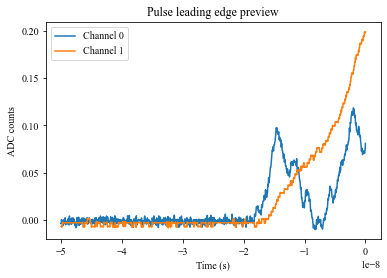

In [5]:
# Plot an event for analysis
# Zoom pulse leading edge

# Inputs:
evt_nb = 17 # Select the number of event (between 0 to 99)
smp_le = 5000 # Select the number of samples in leading edge for preview

evt_smp = 100000 # Number of samples in an event
evt_sta = evt_nb * evt_smp # Event start
evt_end = evt_sta + smp_le - 1 # Event end
evt_rng = range(evt_sta, evt_end) # Event range

plt.plot(x0[evt_rng], y0[evt_rng], label="Channel 0") # Plot channel 0 
plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1
plt.xlabel('Time (s)')
plt.ylabel('ADC counts')
plt.title('Pulse leading edge preview')
plt.legend()

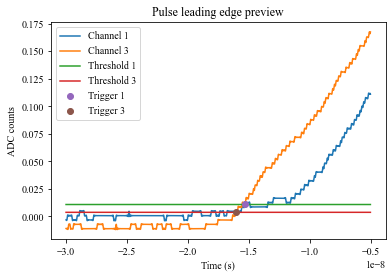

In [6]:
# Pulse processing for each event
# For this test, channels 1 and 3 will be used because the pulses are unipolar

# Inputs:
evt_tot = 100 # Total number of events
bas_tot = 1000 # Total number of samples to baseline calculation

evt_smp = 100000 # Number of samples in an event
ene_y1 = np.zeros(evt_tot) # Energy for each event in channel 1
ene_y3 = np.zeros(evt_tot) # Energy for each event in channel 3

#for evt_nb in range(evt_tot):
for evt_nb in range(0, 1):

    # List of events with problems. Verify these events in item 1
    blc_lst = [32, 34, 95] # avoid these events
    if evt_nb in blc_lst:
        continue

    evt_sta = evt_nb * evt_smp # Event start
    evt_end = evt_sta + evt_smp - 1 # Event end
    evt_rng = range(evt_sta, evt_end) # Event range

    # Baseline calculation - Average Moving Method
    # In the Average Moving Method, the average is calculated from the beginning 
    # of the event to the sample referring to the trigger.
    # But for simplification, the average will be calculated up to bas_tot sample 
    bas_y1 = np.mean(y1[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 1
    bas_y3 = np.mean(y3[evt_sta:evt_sta + bas_tot]) # Baseline value for channel 3    

    # Threshold calculation 
    # For simplification the threshold will be estimed in 6 sigmas aprox.
    thr_y1 = bas_y1 + 6 * np.std(y1[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 1
    thr_y3 = bas_y3 + 6 * np.std(y3[evt_sta:evt_sta + bas_tot]) # Threshold value for channel 3

    # Trigger
    trg_s1 = next(y for y in evt_rng if y1[y] > thr_y1) # Trigger sample for channel 1
    trg_s3 = next(y for y in evt_rng if y3[y] > thr_y3) # Trigger sample for channel 3
    trg_y1 = y1[trg_s1] # Trigger value for channel 1
    trg_y3 = y3[trg_s3] # Trigger value for channel 3
    trg_x1 = x0[trg_s1] # Trigger time for channel 1
    trg_x3 = x0[trg_s3] # Trigger time for channel 3

    # Energy calculation
    ene_y1[evt_nb] = sum(y for y in y1[trg_s1:evt_end] if y > thr_y1) # Energy of event for channel 1
    ene_y3[evt_nb] = sum(y for y in y3[trg_s3:evt_end] if y > thr_y3) # Energy of event for channel 3  

    # Select ONLY ONE event to view threshold in leading edge of pulse    
    smp_le_end = 2500 # Select the number of samples in leading edge for preview    
    smp_le_sta = 2000 # Select the number of samples in leading edge for preview    
    evt_sta = evt_nb * evt_smp + smp_le_sta# Event start
    evt_end = evt_sta + smp_le_end - 1 # Event end
    evt_rng = range(evt_sta, evt_end) # Event range
        
    plt_thr_y1 = np.ones(evt_end - evt_sta) * thr_y1
    plt_thr_y3 = np.ones(evt_end - evt_sta) * thr_y3
    plt.plot(x0[evt_rng], y1[evt_rng], label="Channel 1") # Plot channel 1 
    plt.plot(x0[evt_rng], y3[evt_rng], label="Channel 3") # Plot channel 3
    plt.plot(x0[evt_rng], plt_thr_y1, label="Threshold 1") # Plot threshold 1
    plt.plot(x0[evt_rng], plt_thr_y3, label="Threshold 3") # Plot threshold 3    
    plt.plot(trg_x1, trg_y1, 'o', label="Trigger 1") # Plot trigger 1
    plt.plot(trg_x3, trg_y3, 'o', label="Trigger 3") # Plot trigger 3
    plt.xlabel('Time (s)')
    plt.ylabel('ADC counts')
    plt.title('Pulse leading edge preview')
    plt.legend()